<div style="text-align: center;"> <h3>Data Mining and Wrangling</h3>
<h5>Formative Assessment 5</h5>
<h5>Arpil 30, 2025</h5>    
<h5><u>By Romand Lansangan</u></h5>
    </div>
    
---

## Case study: Titanic Dataset

**Objective**: The objective of this assessment is to develop an understanding of logistic regression and its application in binary classification tasks. You will implement logistic regression using the Titanic dataset, analyze model performance, and interpret the results.

**Dataset**:
For this assignment, you will use the Titanic dataset, which contains passenger information and their survival status. You can download the dataset from the following sources:

Kaggle: https://www.kaggle.com/c/titanic/data

Seaborn’s built-in dataset (sns.load_dataset('titanic') in Python)


### 1.1 Import

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [41]:
df =  sns.load_dataset("titanic")
print("Shape:", f"{df.shape[0]} X {df.shape[1]}")
df.head()

Shape: 891 X 15


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB



The dataset includes the following key features:

* pclass: Passenger class (1st, 2nd, 3rd)

* sex: Gender of the passenger

* age: Age of the passenger

* sibSp: Number of siblings/spouses aboard

* parch: Number of parents/children aboard

* fare: Ticket fare

* embarked: Port of embarkation

* survived: Target variable (0 = No, 1 = Yes)

and some unnecessary columns. More on that later.

### Split

To prevent data leakage, let us split the data first into training and testing batches.

In [43]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)

Shape of df_train: (712, 15)
Shape of df_test: (179, 15)


### EDA

#### Cardinality

In [44]:
df_train.nunique()

survived         2
pclass           3
sex              2
age             83
sibsp            7
parch            7
fare           220
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

As we can see, most of these are categorical data. `fare` and `age` are the only continous variables.

In [45]:
df_train.embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [46]:
df_train.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', nan], dtype=object)

In [47]:
del df_train['embarked']

In [48]:
df_train.alive.unique()

array(['no', 'yes'], dtype=object)

In [49]:
df_train.survived.unique()

array([0, 1], dtype=int64)

In [50]:
mask = ((df_train['alive'] == 'no') & (df_train['survived'] == 0)) | ((df_train['alive'] == 'yes') & (df_train['survived'] == 1))
len(df_train) - mask.sum()

0

`alive` and `survive` are exactly the same.

In [51]:
del df_train['alive']

#### Missing Data

In [52]:
df_train.isna().sum() * 100 / len(df_train)

survived        0.000000
pclass          0.000000
sex             0.000000
age            19.662921
sibsp           0.000000
parch           0.000000
fare            0.000000
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.808989
embark_town     0.280899
alone           0.000000
dtype: float64

For the missing values in `age` we can just impute the average age.

For the missing values in `embark_town`, we can impute the majority class.

For the deck however, this much more complicated.

In [56]:
df_train.deck.unique()

['C', NaN, 'B', 'F', 'D', 'E', 'A', 'G']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [61]:
df_train_copy = df_train.copy()

df_train_copy['deck'] = df_train_copy['deck'].astype("object").fillna("None")

In [63]:
df_train_copy.groupby(["deck", 'pclass']).count()['sex']

deck  pclass
A     1          10
B     1          38
C     1          52
D     1          17
      2           2
E     1          18
      2           3
      3           3
F     2           7
      3           5
G     3           3
None  1          28
      2         139
      3         387
Name: sex, dtype: int64

Maybe these are the people who are not assigned any particular deck or cabin.

We can make it into it's own category.

#### Imputation

In [67]:
mean_age = df_train['age'].mean()
df_train['age'] = df_train['age'].fillna(mean_age)

In [76]:
majority_class = df_train['embark_town'].value_counts(ascending=False).index[0]
df_train['embark_town'] = df_train['embark_town'].fillna(majority_class)

In [77]:
df_train['deck'] = df_train['deck'].astype("object").fillna("None")

In [78]:
df_train.isna().sum() * 100 / len(df_train)

survived       0.0
pclass         0.0
sex            0.0
age            0.0
sibsp          0.0
parch          0.0
fare           0.0
class          0.0
who            0.0
adult_male     0.0
deck           0.0
embark_town    0.0
alone          0.0
dtype: float64

### Data type


In [94]:
df_train.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
class          category
who              object
adult_male         bool
deck             object
embark_town      object
alone              bool
dtype: object

### Distribution

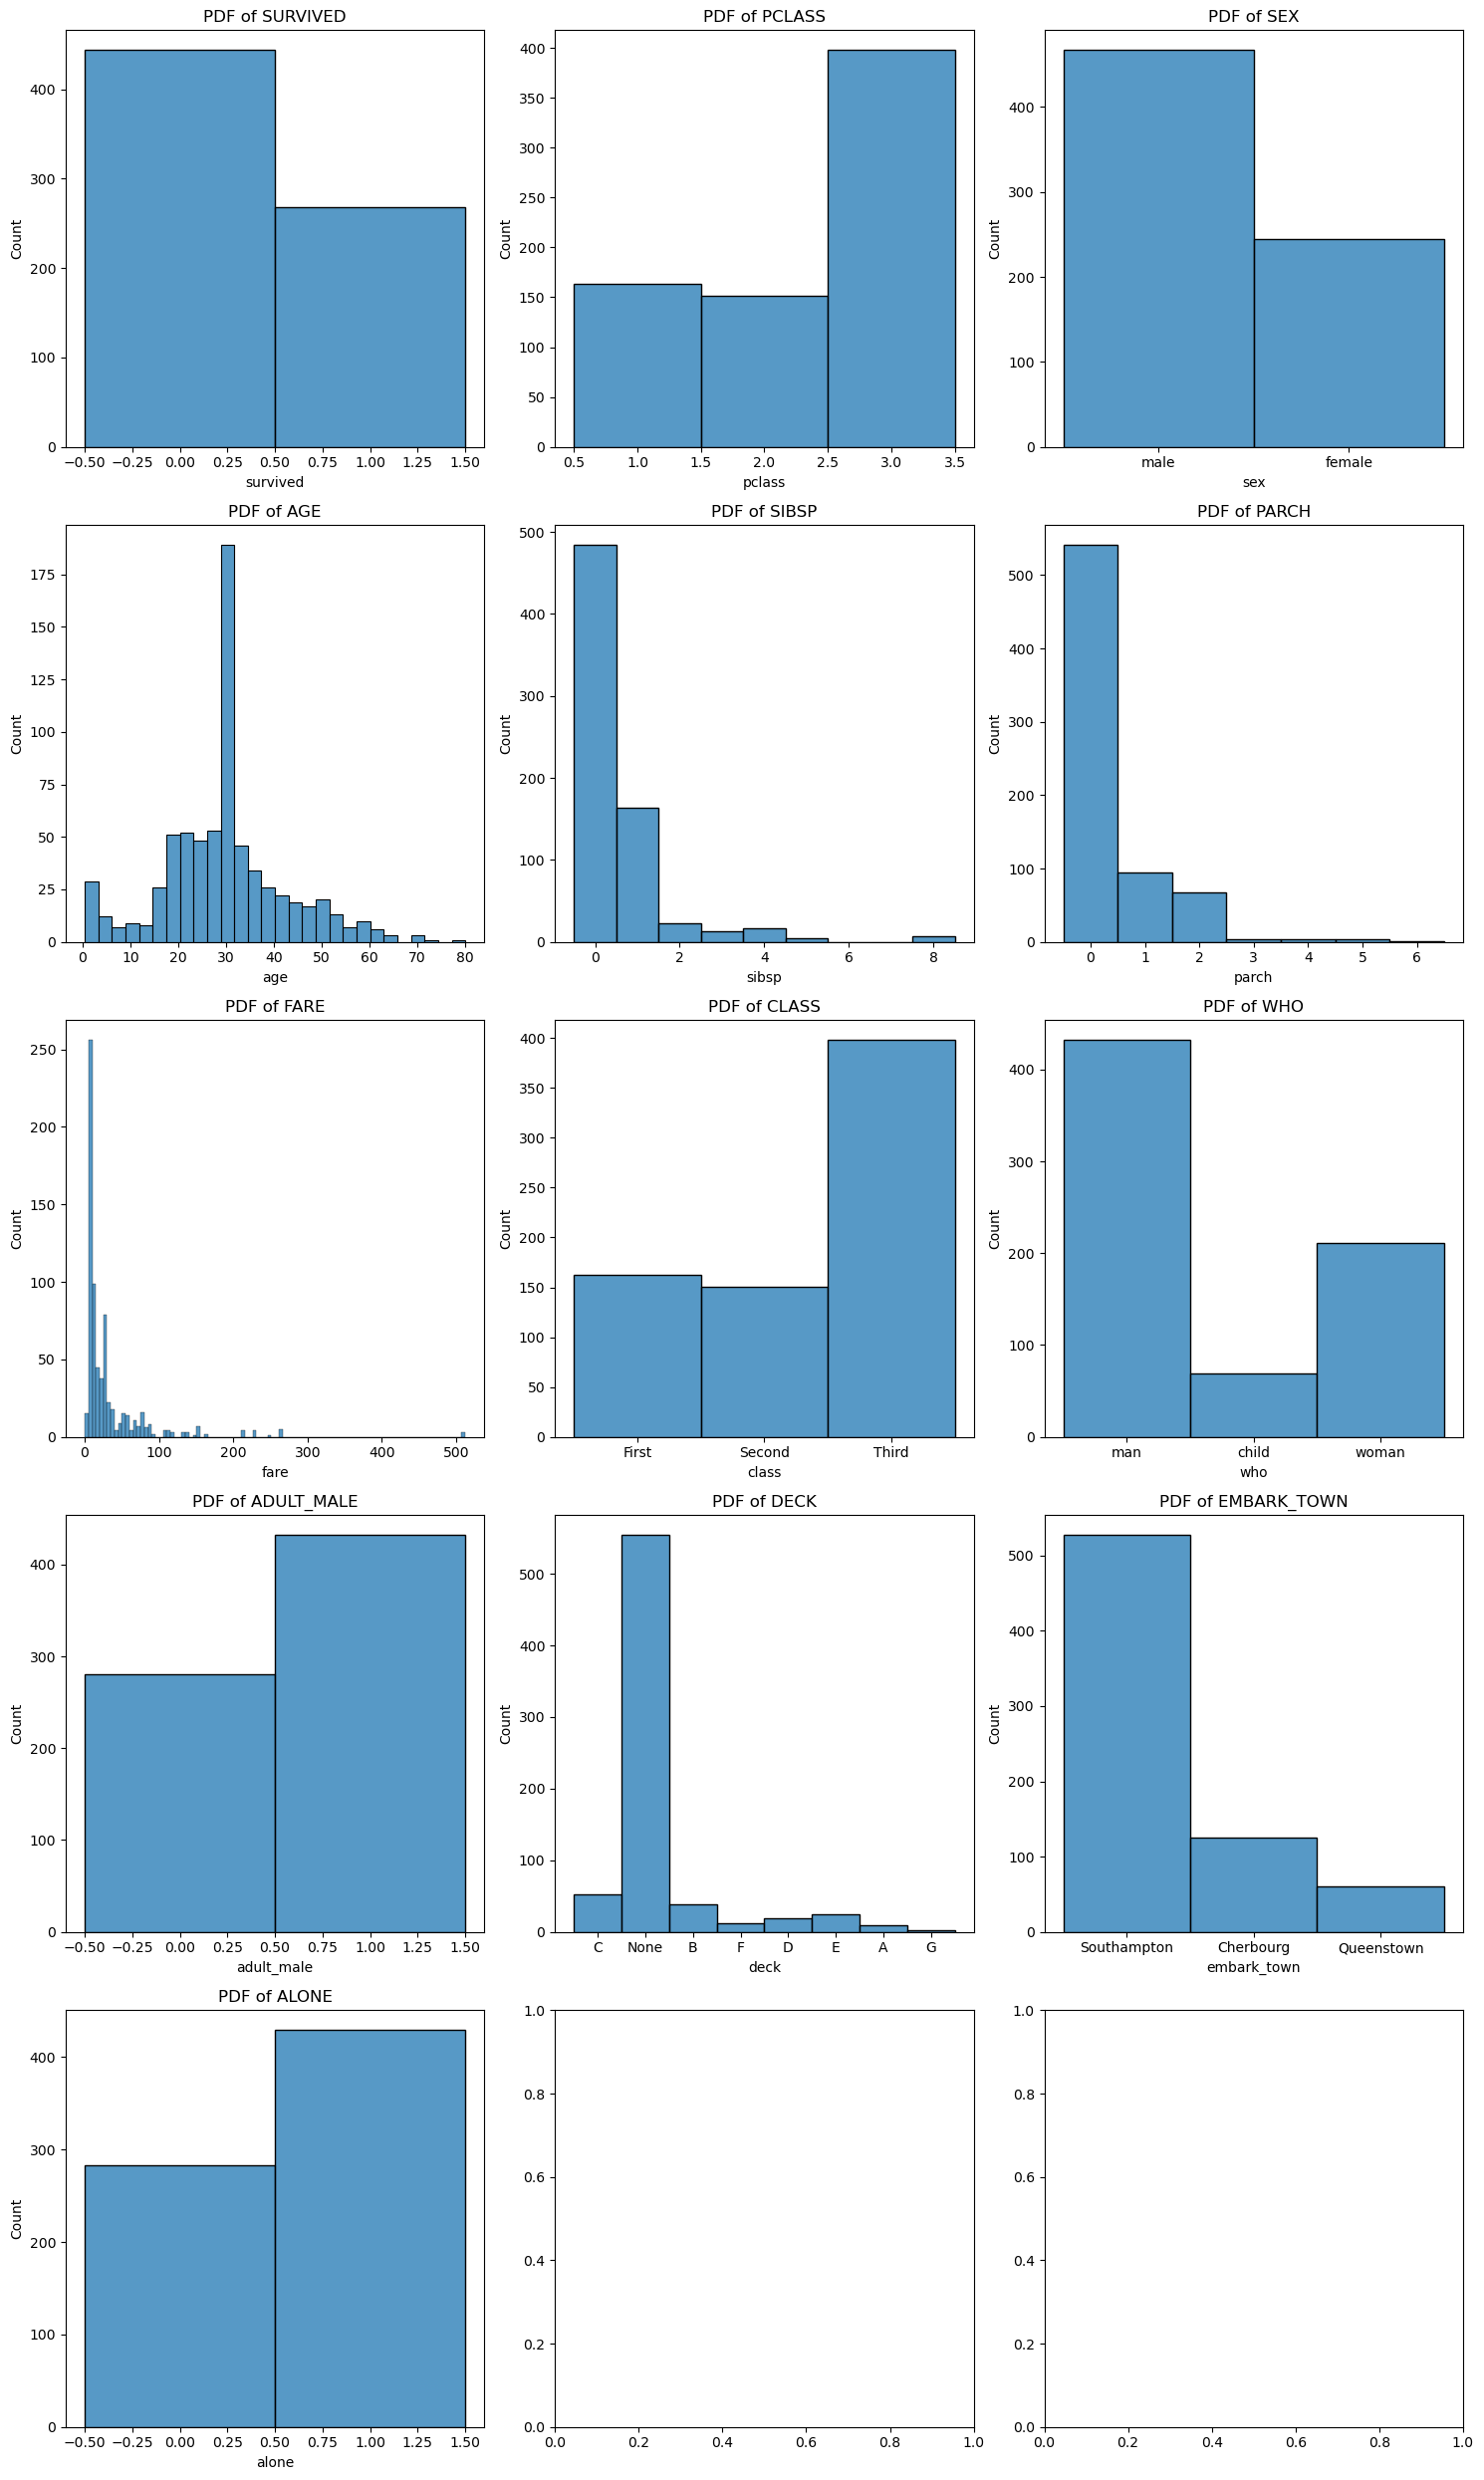

In [128]:
rows = int(np.ceil(df_train.shape[1]/3))

fig, axes = plt.subplots(ncols=3, nrows=rows, figsize=(15, 5*rows))

axes = axes.flatten()
cols = df_train.columns.to_list()

for ind, col in enumerate(cols):
    sns.histplot(df_train[col], ax=axes[ind], discrete=df_train[col].nunique() < 10)
    axes[ind].set_title(f"PDF of {col.upper()}")

plt.tight_layout()

### Correlation

In [126]:
cor = df_train.corr()

sns.heatmap(cor, annot=True)

ValueError: could not convert string to float: 'male'